# The Price is Right

Today we build a more complex solution for estimating prices of goods.

1. Day 2.0 notebook: create a RAG database with our 400,000 training data
2. Day 2.1 notebook: visualize in 2D
3. Day 2.2 notebook: visualize in 3D
4. Day 2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Day 2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

Phew! That's a lot to get through in one day!

## PLEASE NOTE:

We already have a very powerful product estimator with our proprietary, fine-tuned LLM. Most people would be very satisfied with that! The main reason we're adding these extra steps is to deepen your expertise with RAG and with Agentic workflows.

## Finishing off with Random Forests & Ensemble

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [2]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "/Volumes/BlueData/autonomous_agent_system/vectorstore"

In [3]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Load in the test pickle file:

with open('/Volumes/BlueData/autonomous_agent_system/test.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [6]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Random Forest

We will now train a Random Forest model.

Can you spot the difference from what we did in Week 6? In week 6 we used the word2vec model to form vectors; this time we'll use the vectors we already have in Chroma, from the SentenceTransformer model.

In [ ]:
# # This next line takes an hour on my M1 Mac!

# rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# rf_model.fit(vectors, prices)

In [ ]:
# # Save the model to a file

# joblib.dump(rf_model, 'random_forest_model.pkl')

In [7]:
# Load it back in again

rf_model = joblib.load('/Volumes/BlueData/autonomous_agent_system/random_forest_model.pkl')

/Users/alicia/miniconda3/envs/llms/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/alicia/miniconda3/envs/llms/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [9]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

/Users/alicia/miniconda3/envs/llms/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/alicia/miniconda3/envs/llms/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [11]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $289.99 Truth: $374.41 Error: $84.42 SLE: 0.06 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $196.65 Truth: $225.11 Error: $28.46 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $213.42 Truth: $61.68 Error: $151.74 SLE: 1.51 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $364.84 Truth: $599.99 Error: $235.15 SLE: 0.25 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $195.52 Truth: $16.99 Error: $178.53 SLE: 5.72 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $69.63 Truth: $31.99 Error: $37.64 SLE: 0.58 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $275.91 Truth: $101.79 Error: $174.12 SLE: 0.98 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $222.00 Truth: $289.00 Error: $67.00 SLE: 0.07 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $275.46 Truth: $635.86 Error: $360.40 SLE: 0.70 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $182.72 Truth: $65.99 Error: $116.73 SLE

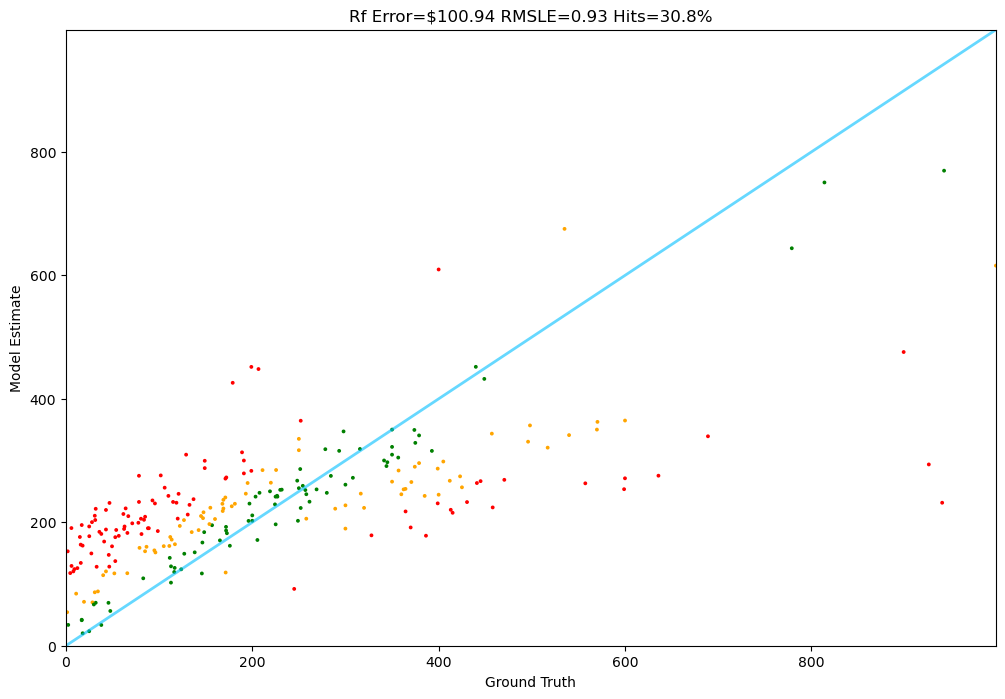

In [12]:
Tester.test(rf, test)

In [14]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [15]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

189.0
139.99
285.35880000000014


In [16]:
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

  2%|▏         | 6/250 [00:28<19:30,  4.80s/it]


KeyboardInterrupt: 

In [16]:
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [ ]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

In [ ]:
joblib.dump(lr, '/Volumes/BlueData/autonomous_agent_system/ensemble_model.pkl')

In [17]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

/Users/alicia/miniconda3/envs/llms/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/alicia/miniconda3/envs/llms/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [18]:
ensemble.price(product)

166.9574755825307

In [19]:
def ensemble_pricer(item):
    return ensemble.price(description(item))

1: Guess: $406.51 Truth: $374.41 Error: $32.10 SLE: 0.01 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $207.15 Truth: $225.11 Error: $17.96 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $51.41 Truth: $61.68 Error: $10.27 SLE: 0.03 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $375.50 Truth: $599.99 Error: $224.49 SLE: 0.22 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $38.20 Truth: $16.99 Error: $21.21 SLE: 0.61 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $42.14 Truth: $31.99 Error: $10.15 SLE: 0.07 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $99.37 Truth: $101.79 Error: $2.42 SLE: 0.00 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $387.27 Truth: $289.00 Error: $98.27 SLE: 0.09 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $898.39 Truth: $635.86 Error: $262.53 SLE: 0.12 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $78.96 Truth: $65.99 Error: $12.97 SLE: 0.03 It

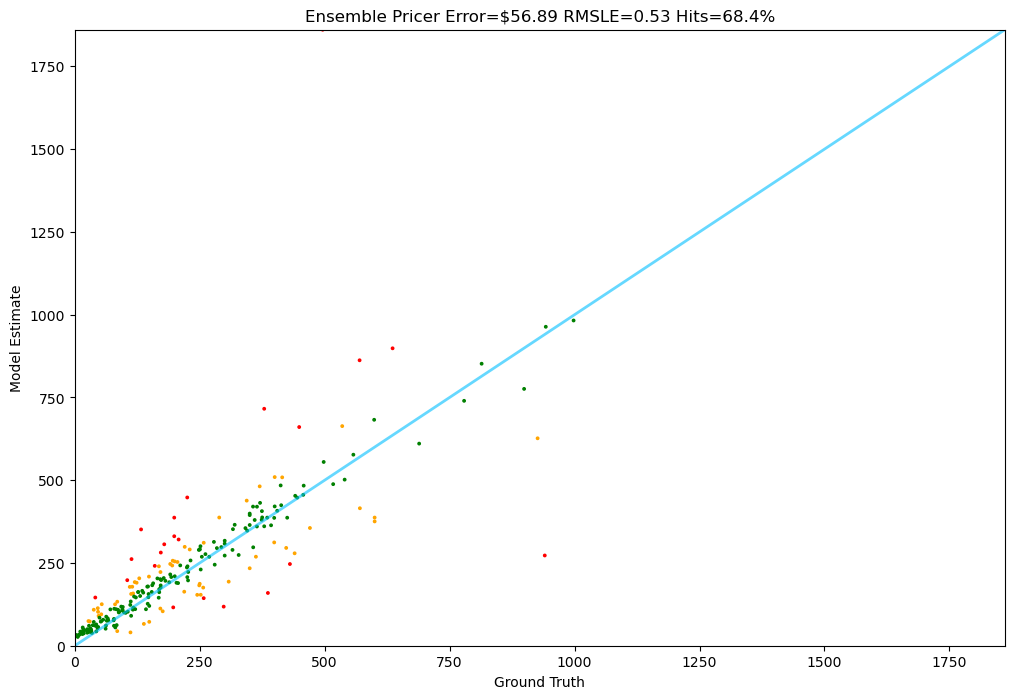

In [20]:
Tester.test(ensemble_pricer, test)

# WHAT A DAY!

We got so much done - a Fronter RAG pipeline, a Random Forest model using transformer-based encodings, and an Ensemble model.

You can do better, for sure!

Tweak this, and try adding components into the ensemble, to beat my performance.